# Experimenting with ML models
In this notebook, I'm experimenting with a few different models, to see which might be the most favorable option
TODO: Change ALL of this to reflect the fact that I reduced that cardinality of my categorical variables AND filled in model year null values to workaround having to use the imputer, which totally screws the process of trying to use shap and pdp

In [1]:
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest

In [125]:
# Read in data
path = '../data/guitars.csv'
guitars = pd.read_csv(path)

In [126]:
# Remove crazy outliers above $10,000
guitars = guitars.drop(index=guitars.loc[guitars['Price'] > 9999.99].index)

In [127]:
def wrangle(X):
    '''Bulk wrangle for split data'''
    
    # Avoid setting with copy
    X = X.copy()
    
    # Set feature thresholds
    model_limit = 30 # was 20
    brand_limit = 30 # was 20
    color_limit = 30 # was 20
    material_limit = 30 # was 20
    btype_limit = 15 # was 15
    size_limit = 10
    pline_limit = 30 # was 20
    
    # Clean conditions column text
    X['Condition'] = X['Condition'].str.replace('\:\D+', '')
    
    # Make null values out of the incorrectly entered categories
    conditions = ['Used', 'New', 'Open box', 'Seller refurbished',
                  'For parts or not working', 'Manufacturer refurbished']
    
    X.loc[~X['Condition'].isin(conditions), 'Condition'] = np.nan
    
    # Combine columns that are obviously the same and where values are null
    to_merge = {'Right-/ Left-Handed': ['Dexterity', 'Hand'],
                'Country/Region of Manufacture': ['Country of Manufacture'], 
                'Body Color': ['Color'], 'Body Type': ['Type']}
    for main_feat, dup_feat in to_merge.items():
        for f in dup_feat:
            condition = X[main_feat].isnull() & ~X[f].isnull()
            X.loc[condition, main_feat] = X[f]
            # Drop column after merge
        X = X.drop(columns=dup_feat)
    
    # TODO: fix right-left hand business
    # Reduce categories in the right-/ left hand column
    X['Orientation'] = X['Right-/ Left-Handed'].str.upper()
    X['Orientation'] = X['Orientation'].str.replace(
        '(RIGHT OR LEFT|LEFT OR RIGHT|EITHER|LAP|RIGHT-HANDED,).*', 
        'BOTH')
    X['Orientation'] = X['Orientation'].str.replace(
        'R.*', 'RIGHT-HANDED')
    X['Orientation'] = X['Orientation'].str.replace(
        'L.*', 'LEFT-HANDED')
    
    # Remove names that aren't real models from top 100
    X['Model'] = X['Model'].str.upper()
    not_a_model = ['DRN979CTV LH BK 2ND', '39" ELECTRIC GUITAR', '2019',
                   'DOES NOT APPLY', 'UNKNOWN', 'GTR235 LH BK 2ND']  
    top_models = X['Model'].value_counts()[:model_limit].index
    
    X.loc[X['Model'].isin(not_a_model), 'Model'] = 'OTHER'
    X.loc[~X['Model'].isin(top_models), 'Model'] = 'OTHER'
    
    # Clean and shrink the brand column
    X['Brand'] = X['Brand'].str.upper()
    X['Brand'] = X['Brand'].str.replace('UNBRANDED.*', 'UNBRANDED')
    top_brands = X['Brand'].value_counts()[:brand_limit].index
    X.loc[~X['Brand'].isin(top_brands), 'Brand'] = 'OTHER'
    
    # Clean and shrink cardinality of the string configuration column
    standard_configs = ['6 STRING', '7 STRING', '8 STRING', '9 STRING', '12 STRING']
    
    X['String Configuration'] = X['String Configuration'].str.upper()
    X['String Configuration'] = X['String Configuration'].str.replace(
        '6\W*STRING(?!78912).*|^6$|6\s*\w*\s*STRINGS(?!78912)', '6 STRING')
    X['String Configuration'] = X['String Configuration'].str.replace('^7$', '7 STRING')
    X['String Configuration'] = X['String Configuration'].str.replace('12\W*STRING', '12 STRING')
    
    X.loc[~X['String Configuration'].isin(standard_configs), 'String Configuration'] = 'OTHER'
    
    # Turn UPC and MPN into included and not included categories
    X['UPC'] = X['UPC'].str.upper()
    X.loc[X['UPC'] != 'DOES NOT APPLY', 'UPC'] = 'PROVIDED'
    X.loc[X['UPC'] == 'DOES NOT APPLY', 'UPC'] = 'NOT AVAILABLE'
    
    # If MPN entry contains a digit, it can be considered a valid entry
    mpn_condition = X['MPN'].str.contains('\d')
    X.loc[mpn_condition == True, 'MPN'] = 'PROVIDED'
    X.loc[mpn_condition == False, 'MPN'] = 'NOT AVAILABLE'
    
    # Reduce size, color and material and product line cardinality
    features_limits = {'Body Color': color_limit,
                       'Body Material': material_limit,
                       'Size': size_limit,
                       'Product Line': pline_limit}
    
    for feat, lim in features_limits.items(): # Apply the same wrangling to 3 features
        X[feat] = X[feat].str.upper()
        top = X[feat].value_counts()[:lim].index
        X.loc[~X[feat].isin(top), feat] = 'OTHER'
    
    # Reduce body type cardinality
    X['Body Type'] = X['Body Type'].str.upper()
    top_btypes = X['Body Type'].value_counts().index[:btype_limit]
    X['Body Type'].str.replace('STRAT.*', 'STRATOCASTER')
    X.loc[~X['Body Type'].isin(top_btypes), 'Body Type'] = 'OTHER'
    
    # Make model year a numeric category
    X.loc[X['Model Year'].str.contains('^\d{4}$') == False, 'Model Year'] = np.nan
    X['Model Year'] = X['Model Year'].astype(float)    
    X['Model Year'] = X['Model Year'].fillna(X['Model Year'].mode()[0])
    
    # Fix country lack of consistency (this is new, but not a huge change)
    X['Country/Region of Manufacture'] = X['Country/Region of Manufacture'].str.upper()
    X['Country/Region of Manufacture'] = X['Country/Region of Manufacture'].str.replace(
    'US|USA', 'UNITED STATES').str.replace('KOREA.*', 'KOREA').str.replace('CN', 'CANADA')
    
    return X

### Beginning With a Baseline
The mean absolute error produced by guessing will help to establish a baseline to begin improving upon. What is the mean absolute error produced by predicting the mean price for every sample

In [128]:
# Start with a baseline
error = guitars['Price'] - guitars['Price'].mean()
mae = error.abs().mean()
print(f'Mean Absolute Error: ${mae:.2f}')

Mean Absolute Error: $505.91


Off by $500 isn't terrible, but for some guitar sales on eBay, that may be completely off the mark, like in the case of guitars sold for ridiculously low prices, i.e. for parts or not working.

### Exploring ML models
Just for comparison's sake, I'm exploring the error produced by a few regression techniques with default parameters. 

In [129]:
# Split into train and test in preparation for cross-validation
train, test = train_test_split(guitars, train_size=0.8, random_state=42)

# Apply wrangling to train and test
train = wrangle(train)
test = wrangle(test)


In [130]:
train.shape, test.shape

((9956, 33), (2489, 33))

In [131]:
# Arrange data into for CV
target = 'Price'
features = ['Model', 'MPN', 'Body Color', 'Brand', 
            'UPC', 'Body Material', 'Body Type', 
            'Model Year', 'Size', 'Country/Region of Manufacture',
            'String Configuration', 'Orientation', 
            'Product Line','Condition']
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [132]:
# Fit pipeline for a basic Linear Regression, get cross validated error

pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    StandardScaler(),
    SelectKBest(f_regression, k=40),
    LinearRegression()
)

k=3
scores = cross_val_score(pipeline, X_train, y_train, cv=k,
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)
print(f'Mean of {k} scores:', -scores.mean())

MAE for 3 folds: [385.03705514 376.42908933 386.80222203]
Mean of 3 scores: 382.7561221647796


An error of ~$400 is better than guessing, but not by enough. How does the error look with a random forest regressor?

In [133]:
# Fit pipeline for a random forest regressor, get cross validated error

pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)

k=5
scores = cross_val_score(pipeline, X_train, y_train, cv=k,
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)
print(f'Mean of {k} scores:', -scores.mean())

MAE for 5 folds: [307.13371392 300.74656998 296.70123641 299.12675968 297.34280001]
Mean of 5 scores: 300.21021600003525


~$300 gets even closer, but it's likely that things can be done to get even closer still, without overfitting the data. The price column is heavily right skewed, so there is some log transformation in order.

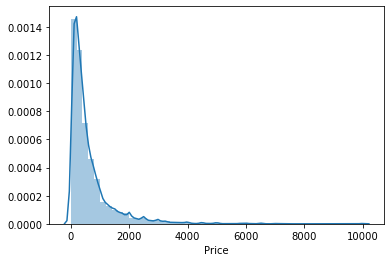

In [134]:
# Visualize skew in price
import seaborn as sns
sns.distplot(y_train);

# TODO: Save figure for process page in web app

### Log Transformation
If I log transorm the price, the distribution looks a little more normal

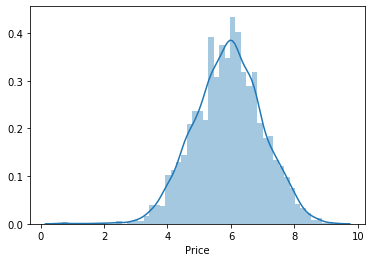

In [135]:
y_log = np.log1p(y_train)
sns.distplot(y_log);

Does the baseline error improve after this transformation?

In [136]:
error = y_log - y_log.mean()
mae_transformed = error.abs().mean()

# Untransform mae
mae = np.expm1(mae_transformed)
print(f'Mean Absolute Error of Log Transformed y: ${mae:.2f}')

Mean Absolute Error of Log Transformed y: $1.35


After transformation, the baseline gets down to less than $2 of error. Does that mean that the models tried before will do much better than before with a log transformed price?

In [137]:
# Fit pipeline for a basic Linear Regression, get cross validated erro

pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    StandardScaler(),
    SelectKBest(f_regression, k=40),
    LinearRegression()
)

k=3
scores = cross_val_score(pipeline, X_train, y_log, cv=k,
                         scoring='neg_mean_absolute_error')
scores_untransformed = np.expm1(scores)
print(f'MAE for {k} folds:', -scores_untransformed)
print(f'Mean of {k} scores:', -scores_untransformed.mean())

MAE for 3 folds: [0.47251462 0.4666529  0.47515321]
Mean of 3 scores: 0.47144024355713626


Now the linear regression model's error is down below $1

In [138]:
# Fit pipeline for a random forest regressor, get cross validated error

pipeline = make_pipeline(
    ce.OneHotEncoder(),
    SimpleImputer(),
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)

k=5
scores = cross_val_score(pipeline, X_train, y_log, cv=k,
                         scoring='neg_mean_absolute_error')
scores_untransformed = np.expm1(scores)
print(f'MAE for {k} folds:', -scores_untransformed)
print(f'Mean of {k} scores:', -scores_untransformed.mean())

MAE for 5 folds: [0.39448907 0.39596898 0.39562525 0.39433068 0.40089986]
Mean of 5 scores: 0.3962627681776716


With a random forest regressor, the error lies below 40 cents

### XGBoost and Permutation Importance

In [139]:
from xgboost import XGBRegressor
import warnings
import eli5
from eli5.sklearn import PermutationImportance
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [140]:
# Split again into train and validation set for permutation importances
train, val = train_test_split(train, train_size=0.8, random_state=42)

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

train.shape, val.shape

((7964, 33), (1992, 33))

In the random forest model, what were the most important features? To answer this question, I'll use a permutation importance visualization to display the weight of each feature

In [141]:
# Use pipeline for transformers only
transformers = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
)

# Log Transform y_train and y_val
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
# Fit the model to the transformed X_train and y_log
model.fit(X_train_transformed, y_train_log)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [142]:
%%time
# Calculate permutation importance
permuter = PermutationImportance(
    model,
    scoring='neg_mean_absolute_error',
    n_iter=5,
    random_state=42
)
permuter.fit(X_val_transformed, y_val_log)

CPU times: user 1min 52s, sys: 6.78 s, total: 1min 58s
Wall time: 2min 10s


PermutationImportance(cv='prefit',
                      estimator=RandomForestRegressor(bootstrap=True,
                                                      ccp_alpha=0.0,
                                                      criterion='mse',
                                                      max_depth=None,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      max_samples=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=100

In [143]:
# Display permutation importances
feature_names = X_val_transformed.columns.tolist()
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names# Show all
)

Weight,Feature
0.1515 ± 0.0129,Country/Region of Manufacture_UNITED STATES
0.0976 ± 0.0104,Model Year
0.0682 ± 0.0078,Brand_OTHER
0.0396 ± 0.0044,Brand_UNBRANDED
0.0350 ± 0.0048,Brand_GIBSON
0.0309 ± 0.0087,Size_OTHER
0.0192 ± 0.0052,MPN_PROVIDED
0.0182 ± 0.0035,Country/Region of Manufacture_JAPAN
0.0150 ± 0.0079,Body Color_BLACK
0.0146 ± 0.0019,Product Line_OTHER


It Looks like all the features I had previously chosen have an considerable effect on price, namely Brand and Country/Region of Manufacture

In [144]:
# Fit XGBoost, stop early
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train, y_train_log)
X_val_encoded = encoder.transform(X_val)

model = XGBRegressor(
    n_estimators=1000,
    random_state=42, 
    n_jobs=-1, 
    max_depth=16,
    learning_rate=0.5,
    )

eval_set = [(X_train_encoded, y_train_log),
            (X_val_encoded, y_val_log)]

model.fit(X_train_encoded, y_train_log,
          eval_set=eval_set,
          eval_metric='mae',
          early_stopping_rounds=100)

[14:49:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1572314959925/work/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-mae:2.72119	validation_1-mae:2.71186
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 100 rounds.
[1]	validation_0-mae:1.41587	validation_1-mae:1.4102
[2]	validation_0-mae:0.823422	validation_1-mae:0.852054
[3]	validation_0-mae:0.593	validation_1-mae:0.648849
[4]	validation_0-mae:0.482659	validation_1-mae:0.575034
[5]	validation_0-mae:0.439341	validation_1-mae:0.555316
[6]	validation_0-mae:0.421877	validation_1-mae:0.548824
[7]	validation_0-mae:0.416311	validation_1-mae:0.545789
[8]	validation_0-mae:0.387263	validation_1-mae:0.540057
[9]	validation_0-mae:0.383049	validation_1-mae:0.539787
[10]	validation_0-mae:0.368783	validation_1-mae:0.536935
[11]	validation_0-mae:0.363848	validation_1-mae

Stopping. Best iteration:
[37]	validation_0-mae:0.217299	validation_1-mae:0.517925



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.5, max_delta_step=0,
             max_depth=16, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

The xgboost did not perform as well on the validation set as the cross validated model, but this does not necessarily mean that it will perform poorly on the test set; the error is still below $1

In [145]:
from sklearn.metrics import mean_absolute_error, r2_score
y_pred = model.predict(X_val_encoded)
mae = mean_absolute_error(y_val_log, y_pred)
mae_untransformed = np.expm1(mae)
mae_untransformed

0.6785413855653304

What is the R^2 score?

In [146]:
r2_score(y_val_log, y_pred)

0.5059618548048573

### Model Interpretation
How does being a Gibson brand guitar affect the model's prediction?

In [147]:
from pdpbox.pdp import pdp_isolate, pdp_plot
# TODO: Try using a model with one hot encoder to represent pdp for categorical variables
feature = 'Brand_GIBSON'

isolated = pdp_isolate(
    model=model,
    dataset=X_val_encoded,
    model_features=X_val_encoded.columns,
    feature=feature
)

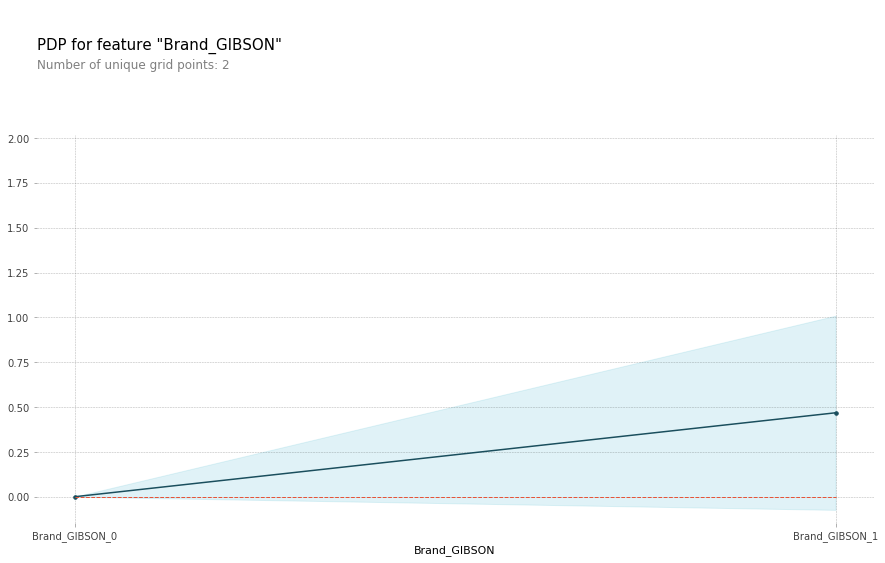

In [148]:
pdp_plot(isolated, feature_name=feature);

In [151]:
import shap

row = X_val_transformed.iloc[[456]]
row

,Model_OTHER,Model_CLASSIC,Model_CUSTOM,Model_VINTAGE,Model_LES PAUL STANDARD,Model_LES PAUL CUSTOM,Model_LES PAUL TRADITIONAL,Model_LES PAUL,Model_STRATOCASTER DELUX,Model_PLUS,...,Product Line_DIAMOND SERIES,Product Line_CUSTOM SHACK,Product Line_DEAN ML,Condition_New,Condition_Used,Condition_nan,Condition_Open box,Condition_Seller refurbished,Condition_For parts or not working,Condition_Manufacturer refurbished
2586,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [152]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)

In [153]:
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

### What about all the NaN values?
Aside from not looking great on the shap force plot, I wonder how the model's error would change if I created a new category for null values, as they may have some predictive weight (and will work better with an ordinal encoder.

In [154]:
# There are four categories that still contain null values
X_train.isnull().sum()

Model                               0
MPN                              3370
Body Color                          0
Brand                               0
UPC                                 0
Body Material                       0
Body Type                           0
Model Year                          0
Size                                0
Country/Region of Manufacture    4570
String Configuration                0
Orientation                      1780
Product Line                        0
Condition                         608
dtype: int64

In [155]:
def flush_nulls(X):
    X = X.copy()
    
    # Fill all null values with the same value
    X = X.fillna('NOT AVAILABLE')
    
    return X

In [156]:
X_train = flush_nulls(X_train)
X_val = flush_nulls(X_val)
X_test = flush_nulls(X_test)

Now that the null values are all replaced with an explanatory variable, I can try XGBoost with OrdinalEncoder

In [157]:
# Fit XGBoost, stop early
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train, y_train_log)
X_val_encoded = encoder.transform(X_val)

model = XGBRegressor(
    n_estimators=1000,
    random_state=42, 
    n_jobs=-1, 
    max_depth=15,
    learning_rate=0.1,
    objective='reg:squarederror'
    )

eval_set = [(X_train_encoded, y_train_log),
            (X_val_encoded, y_val_log)]

model.fit(X_train_encoded, y_train_log,
          eval_set=eval_set,
          eval_metric='mae',
          early_stopping_rounds=100)

[0]	validation_0-mae:4.87378	validation_1-mae:4.86363
Multiple eval metrics have been passed: 'validation_1-mae' will be used for early stopping.

Will train until validation_1-mae hasn't improved in 100 rounds.
[1]	validation_0-mae:4.38835	validation_1-mae:4.37984
[2]	validation_0-mae:3.952	validation_1-mae:3.94471
[3]	validation_0-mae:3.55984	validation_1-mae:3.55403
[4]	validation_0-mae:3.20723	validation_1-mae:3.20126
[5]	validation_0-mae:2.89016	validation_1-mae:2.88545
[6]	validation_0-mae:2.60574	validation_1-mae:2.60224
[7]	validation_0-mae:2.35034	validation_1-mae:2.3482
[8]	validation_0-mae:2.1217	validation_1-mae:2.12004
[9]	validation_0-mae:1.91728	validation_1-mae:1.91688
[10]	validation_0-mae:1.73465	validation_1-mae:1.73697
[11]	validation_0-mae:1.57223	validation_1-mae:1.57799
[12]	validation_0-mae:1.42736	validation_1-mae:1.43654
[13]	validation_0-mae:1.29903	validation_1-mae:1.31196
[14]	validation_0-mae:1.18475	validation_1-mae:1.20376
[15]	validation_0-mae:1.08313	v

[142]	validation_0-mae:0.148027	validation_1-mae:0.499649
[143]	validation_0-mae:0.147946	validation_1-mae:0.499654
[144]	validation_0-mae:0.147908	validation_1-mae:0.499707
[145]	validation_0-mae:0.147805	validation_1-mae:0.499713
[146]	validation_0-mae:0.147372	validation_1-mae:0.499713
[147]	validation_0-mae:0.147205	validation_1-mae:0.499739
[148]	validation_0-mae:0.146945	validation_1-mae:0.499797
[149]	validation_0-mae:0.146243	validation_1-mae:0.500019
[150]	validation_0-mae:0.145057	validation_1-mae:0.500351
[151]	validation_0-mae:0.144428	validation_1-mae:0.500559
[152]	validation_0-mae:0.144243	validation_1-mae:0.500607
[153]	validation_0-mae:0.143676	validation_1-mae:0.500616
[154]	validation_0-mae:0.14356	validation_1-mae:0.500692
[155]	validation_0-mae:0.143523	validation_1-mae:0.500706
[156]	validation_0-mae:0.14334	validation_1-mae:0.500816
[157]	validation_0-mae:0.142938	validation_1-mae:0.500866
[158]	validation_0-mae:0.142875	validation_1-mae:0.500844
[159]	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=None, n_estimators=1000,
             n_jobs=-1, nthread=None, objective='reg:squarederror',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

The model's performance improved slightly, and the model will be much more interpretable in the web app. 

In [158]:
# Using the same row, after OrdinalEncoding 
row = X_test.iloc[[456]]
row

,Model,MPN,Body Color,Brand,UPC,Body Material,Body Type,Model Year,Size,Country/Region of Manufacture,String Configuration,Orientation,Product Line,Condition
9698,VINTAGE,NOT AVAILABLE,BLUE,OTHER,PROVIDED,OTHER,SOLID,2019.0,OTHER,JAPAN,6 STRING,RIGHT-HANDED,OTHER,Used


In [159]:
explainer = shap.TreeExplainer(model)
row_encoded = encoder.transform(row)
shap_values = explainer.shap_values(row_encoded)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row,
)

In [160]:
from sklearn.metrics import mean_absolute_error
X_test_encoded = encoder.transform(X_test)

y_test_log = np.log1p(y_test)
y_val_pred = model.predict(X_val_encoded)
y_pred = model.predict(X_test_encoded)

raw_val_mae = mean_absolute_error(y_val_log, y_val_pred)
raw_mae = mean_absolute_error(y_test_log, y_pred)
val_mae = np.expm1(raw_val_mae)
mae = np.expm1(raw_mae)
print(f"Final model's validation error: ${mae:.2f}")
print(f"Final model's test error: ${mae:.2f}")

Final model's validation error: $0.65
Final model's test error: $0.65


## Images for the web app
In this final section of this notebook, I'll include a permutation importance chart and an interaction plot for the two most important features (whichever pair makes the most sense to compare) from the xgboost model. The insights page will have a link to both this repo and that of the app itself. 

In [161]:
%%time
# Calculate permutation importance for final xgboostregressor
permuter = PermutationImportance(
    model,
    scoring='neg_mean_absolute_error',
    n_iter=5,
    random_state=42
)
permuter.fit(X_test_encoded, y_test_log)

CPU times: user 5.27 s, sys: 3.22 ms, total: 5.27 s
Wall time: 1.42 s


PermutationImportance(cv='prefit',
                      estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1, gamma=0,
                                             importance_type='gain',
                                             learning_rate=0.1,
                                             max_delta_step=0, max_depth=15,
                                             min_child_weight=1, missing=None,
                                             n_estimators=1000, n_jobs=-1,
                                             nthread=None,
                                             objective='reg:squarederror',
                                             random_state=42, reg_alpha=0,
                                             reg_lambda=1, scale_pos_weight=1,
                             

In [162]:
# Display permutation importances for xgboostregressor
feature_names = X_test_encoded.columns.tolist()
eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.2249 ± 0.0223,Country/Region of Manufacture
0.1869 ± 0.0114,Brand
0.1043 ± 0.0055,Model Year
0.0716 ± 0.0041,Body Type
0.0669 ± 0.0063,Body Color
0.0567 ± 0.0030,Condition
0.0519 ± 0.0069,Product Line
0.0473 ± 0.0083,Body Material
0.0425 ± 0.0064,Size
0.0342 ± 0.0047,String Configuration


In [163]:
brand = 'Brand'
for item in encoder.mapping:
    if item['col'] == brand:
        feature_mapping = item['mapping']
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

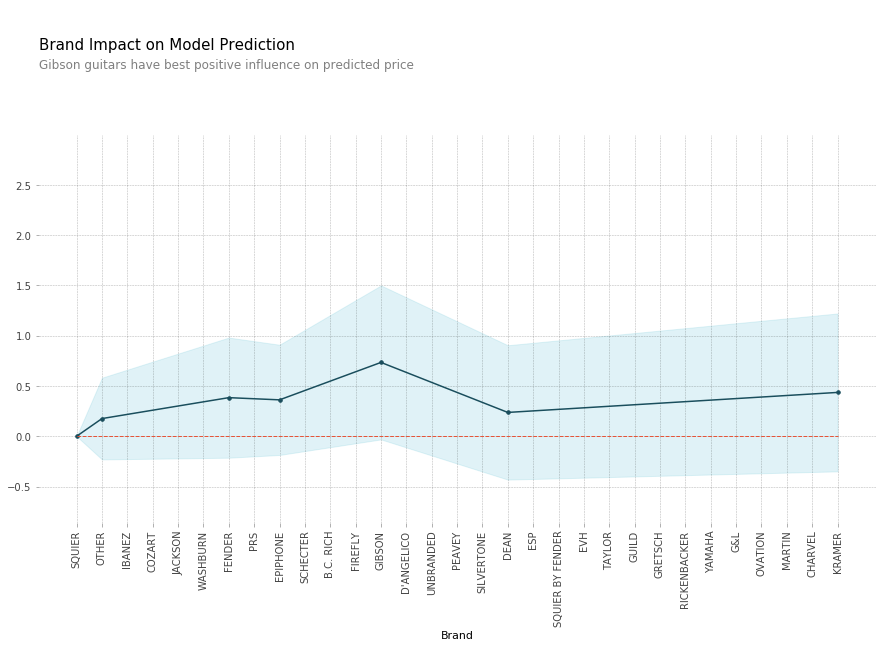

In [173]:
from pdpbox.pdp import pdp_isolate, pdp_plot

isolated = pdp_isolate(
    model=model,
    dataset=X_train_encoded,
    model_features=X_train_encoded.columns,
    feature=brand
)

pdp_plot(
    isolated, feature_name=brand, x_quantile=False,
    plot_params={'title':"Brand Impact on Model Prediction",
                 'subtitle': "Gibson guitars have best positive "\
                             "influence on predicted price"})
plt.xticks(ticks=range(1,32),labels=category_names, rotation=90);
plt.savefig('brand_pdp.png', bbox_inches='tight')

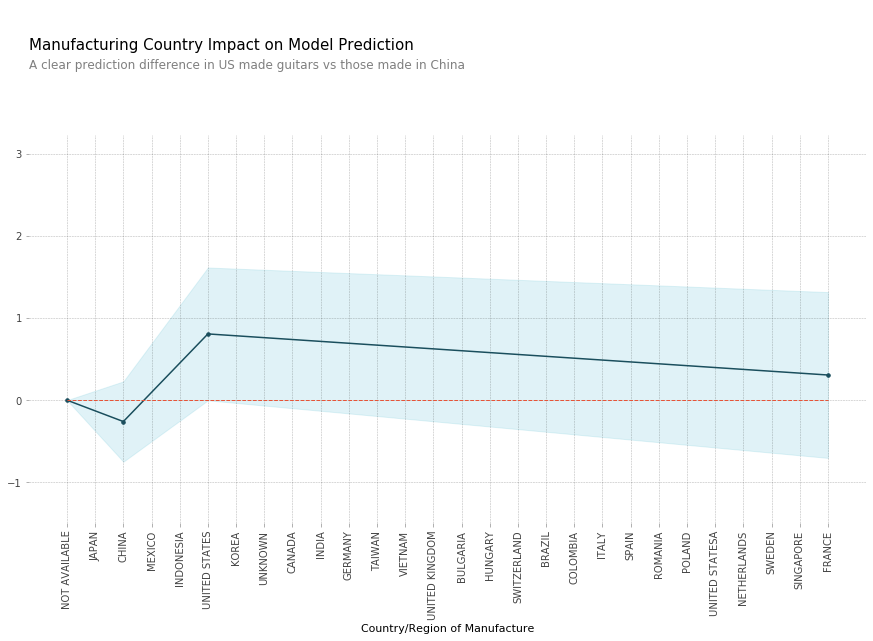

In [176]:
country = 'Country/Region of Manufacture'
for item in encoder.mapping:
    if item['col'] == country:
        country_feature_mapping = item['mapping']
        
country_feature_mapping = country_feature_mapping[country_feature_mapping.index.dropna()]
country_category_names = country_feature_mapping.index.tolist()

isolated = pdp_isolate(
    model=model,
    dataset=X_train_encoded,
    model_features=X_train_encoded.columns,
    feature=country
)

fig = pdp_plot(
    isolated, feature_name=country, x_quantile=False,
    plot_params={'title':"Manufacturing Country Impact on Model Prediction",
                 'subtitle': "A clear prediction difference in "\
                             "US made guitars vs those made in China"})
plt.xticks(ticks=range(1,29),labels=country_category_names, rotation=90);
plt.savefig('country_pdp.png', bbox_inches='tight')